In [2]:
from os import popen
from os import makedirs
from os import listdir as lsdir
from os.path import join as pjoin
from os.path import exists as exist
from pathlib import Path
import glob
import sys
import pandas as pd
import shutil
import time
import obspy
from obspy.clients.fdsn import Client
from obspy import read,read_inventory,read_events
from obspy.core import Stream,UTCDateTime
from obspy.geodetics.base import gps2dist_azimuth
from obspy.taup import TauPyModel
from obspy.signal.rotate import rotate2zne
from obspy.core.util.attribdict import AttribDict
from obspy.signal.trigger import classic_sta_lta,plot_trigger,recursive_sta_lta,trigger_onset
import matplotlib.pyplot as plt
import numpy as np
import glob, os
from scipy.signal import decimate
from sklearn.preprocessing import StandardScaler
import math
from scipy import interpolate

#### Read only Vertical Files

In [9]:
sac = 'Documents/PRJ_AUTO_NOISEPARAM/data/raw/ANMO/*'
anmo_raw_list = []

In [11]:
len(glob.glob(sac))

25584

In [13]:
#glob.glob('ANMO/*')

In [ ]:
for file in glob.glob(sac):
    if file.endswith('.Z'):
        st = read(file)
        tr = st.traces
        
        #getting metadata of the signals
        sample_rate = tr[0].stats.sampling_rate
        numberofsamples = tr[0].stats.npts
        delta_time = tr[0].stats.delta
        total_time_sec = numberofsamples*delta_time
        P_time = tr[0].stats.sac.t0
        data = st.traces[0].data  
        
        #performing de-mean and de-trend to remove any trends in the data and make the noise data zero-centered
        st.detrend(type='demean')
        st.detrend(type='linear')
        data_detrend_demean = st.traces[0].data  
        
        #Need to have all signals follow the same frequency of 20
        data_detrend_demean_antialias = None
        if(numberofsamples == 36000):
            st.filter('lowpass', freq=0.4*20, zerophase=True) # anti-alias filter i.e. little less than the NYquist freq of desired freq.s
            st.decimate(factor=int(40/20), no_filter=True)    # downsample
            data_detrend_demean_antialias = st.traces[0].data
            
        #load into a list to make dataframe with signal and its metadata
        anmo_raw_list.append([sample_rate,numberofsamples,delta_time,\
                              total_time_sec,P_time,data,data_detrend_demean,data_detrend_demean_antialias])

In [ ]:
anmo_raw_df = pd.DataFrame(anmo_raw_list, columns=['sample_rate','sample_numbers','delta_time',\
                                                   'total_time_sec','theoritical_arrival','raw_data',\
                                                   'demean_data','demean_antialias_data'])

print(anmo_raw_df.shape)
anmo_raw_df.head(20)

(4231, 8)


sample_rate  sample_numbers  delta_time  total_time_sec  \
0          40.0           36000       0.025          900.00   
1          40.0           36000       0.025          900.00   
2          40.0           36000       0.025          900.00   
3          20.0           18000       0.050          900.00   
4          20.0           18000       0.050          900.00   
5          40.0           36000       0.025          900.00   
6          20.0           18000       0.050          900.00   
7          40.0           36000       0.025          900.00   
8          20.0           18000       0.050          900.00   
9          20.0           18000       0.050          900.00   
10         20.0           18001       0.050          900.05   
11         20.0           18000       0.050          900.00   
12         20.0           18000       0.050          900.00   
13         40.0           36000       0.025          900.00   
14         40.0           36000       0.025          900.00   
15         20.0           18000       0.050          900.00   
16         40.0           36000       0.025          900.00   
17         40.0           36000       0.025          900.00   
18         20.0           18000       0.050          900.00   
19         40.0           36000       0.025          900.00   

    theoritical_arrival                                           raw_data  \
0                 300.0  [-36082.992, -35667.336, -35198.68, -34786.023...   
1                 300.0  [314.14166, 340.14294, 375.14423, 421.1455, 44...   
2                 300.0  [1791.995, 1948.9921, 1880.989, 1805.9861, 198...   
3                 300.0  [-2.5067985, -14.507983, -25.509167, -36.51035...   
4                 300.0  [-88.212296, -86.20772, -88.20315, -88.19857, ...   
5                 300.0  [41.41722, 37.417244, 50.417263, 88.41729, 164...   
6                 300.0  [215.59048, 247.58994, 277.5894, 306.58884, 33...   
7                 300.0  [-111.34084, -118.33955, -116.33824, -111.3369...   
8                 300.0  [163.54903, 174.55064, 179.55225, 184.55386, 1...   
9                 300.0  [44.878483, 50.88089, 52.883297, 54.885704, 60...   
10                300.0  [-151.33107, -140.33266, -133.33423, -120.3358...   
11                300.0  [-251.98401, -244.98384, -236.98366, -229.9834...   
12                300.0  [-180.34688, -177.34421, -174.34155, -170.3388...   
13                300.0  [9596.145, 9565.116, 9611.089, 9483.061, 9470....   
14                300.0  [1919.7188, 1877.72, 1893.7211, 1885.7223, 183...   
15                300.0  [143.87236, 160.85571, 172.83907, 181.82242, 1...   
16                300.0  [581.18695, 698.1857, 541.1845, 581.1832, 804....   
17                300.0  [33.292328, 34.294746, 27.297165, 18.299583, 1...   
18                300.0  [-327.2693, -306.27213, -282.27493, -257.27774...   
19                300.0  [-422.82196, -641.82556, -875.8291, -986.8327,...   

                                          demean_data  \
0   [-36082.992, -35667.336, -35198.68, -34786.023...   
1   [314.1417, 340.14297, 375.14426, 421.14554, 44...   
2   [1791.995, 1948.9921, 1880.989, 1805.9861, 198...   
3   [-2.5068038, -14.507989, -25.50917, -36.510357...   
4   [-88.212296, -86.20772, -88.20315, -88.19857, ...   
5   [41.4172, 37.41722, 50.41724, 88.41727, 164.41...   
6   [215.59048, 247.58994, 277.5894, 306.58884, 33...   
7   [-111.34084, -118.33955, -116.33824, -111.3369...   
8   [163.54903, 174.55064, 179.55225, 184.55386, 1...   
9   [44.878483, 50.88089, 52.883297, 54.885704, 60...   
10  [-151.33107, -140.33266, -133.33423, -120.3358...   
11  [-251.98401, -244.98384, -236.98366, -229.9834...   
12  [-180.34688, -177.34421, -174.34155, -170.3388...   
13  [9596.145, 9565.116, 9611.089, 9483.061, 9470....   
14  [1919.7188, 1877.72, 1893.7211, 1885.7223, 183...   
15  [143.87236, 160.85571, 172.83907, 181.82242, 1...   
16  [581.18695, 698.1857, 541.1845, 581.1832, 804....   
17  [33.29233, 

In [ ]:
anmo_raw_df.sample_numbers.value_counts()

36000    2258
18000    1962
18001       4
17999       4
35999       2
18002       1
Name: sample_numbers, dtype: int64

#### Taking the Correctly Sampled and Downsampled Data. Then cutting of to only 5000 samples to keep the pre arival noise only. This data will be of 250 seconds length.

In [17]:
anmo_raw_resampled = []

anmo_raw_df_18K_set1 = anmo_raw_df[anmo_raw_df['sample_numbers']==18000].demean_data
anmo_raw_df_not_18K_set1 = anmo_raw_df[anmo_raw_df['sample_numbers']==36000].demean_antialias_data

anmo_raw_df_18K_set1 = np.stack(anmo_raw_df_18K_set1).astype(None)
anmo_raw_df_not_18K_set1 = np.stack(anmo_raw_df_not_18K_set1).astype(None)

In [18]:
for i in anmo_raw_df_not_18K_set1:
    anmo_raw_resampled.append(i)    
    
for i in anmo_raw_df_18K_set1:
    anmo_raw_resampled.append(i)
    
    
anmo_raw_resampled_arr = np.stack(anmo_raw_resampled)

anmo_raw_resampled_arr_cutoff = anmo_raw_resampled_arr[:,0:5000]

In [30]:
anmo_raw_resampled_arr_cutoff.shape

(5000, 4220)

#### Randomly visualizing the signals

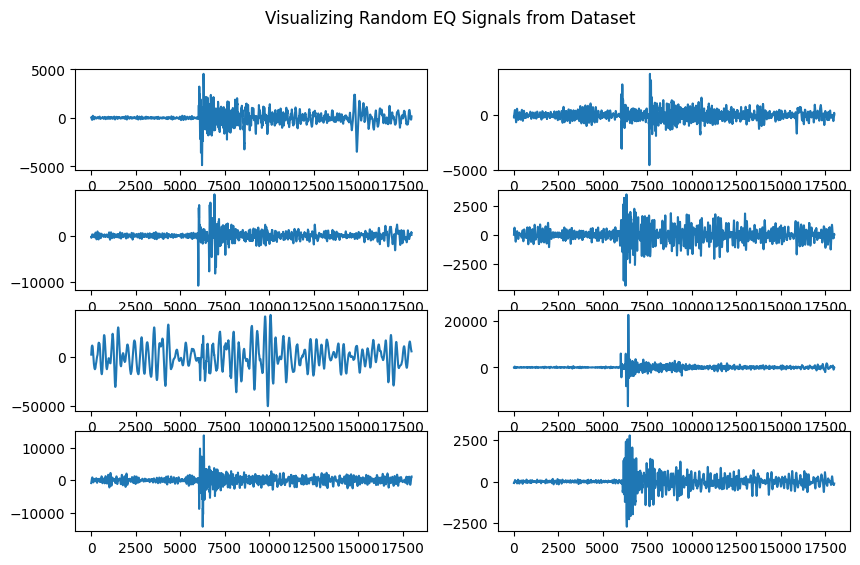

In [11]:
idxorder = np.arange(0,len(anmo_raw_resampled_arr))
np.random.shuffle(idxorder)

plt.figure(1, figsize=(10, 6))

for i in range(1,9):
    plt.subplot(4,2,i)
    plt.plot(anmo_raw_resampled_arr[idxorder[i]])
    
plt.suptitle('Visualizing Random EQ Signals from Dataset')
plt.show()

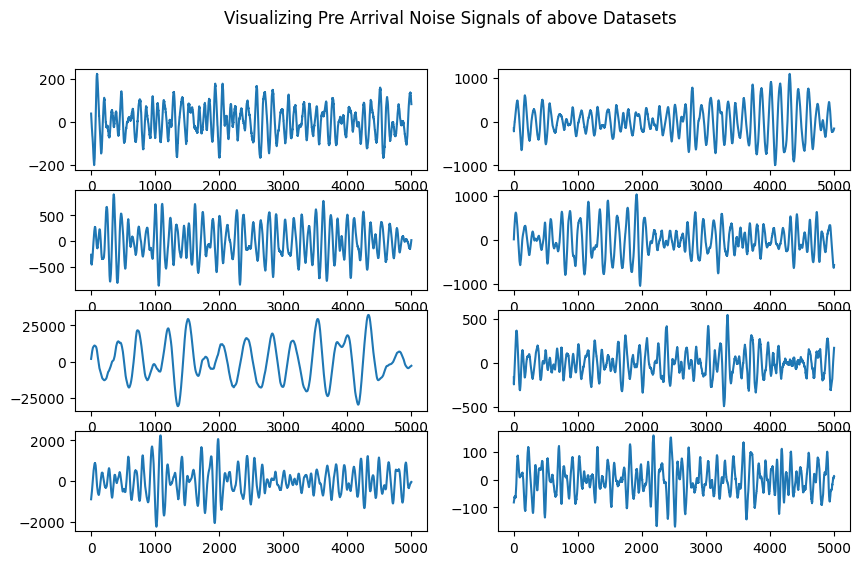

In [12]:
# idxorder = numpy.arange(0,len(anmo_raw_resampled_arr_cutoff))
# numpy.random.shuffle(idxorder)

plt.figure(1, figsize=(10, 6))

for i in range(1,9):
    plt.subplot(4,2,i)
    plt.plot(anmo_raw_resampled_arr_cutoff[idxorder[i]])
    
plt.suptitle('Visualizing Pre Arrival Noise Signals of above Datasets')
plt.show()

#### Building Noise Covariance Matrix

In [19]:
anmo_raw_resampled_arr_cutoff = anmo_raw_resampled_arr_cutoff.T

anmo_raw_resampled_arr_cutoff_norm = StandardScaler().fit_transform(anmo_raw_resampled_arr_cutoff)

anmo_raw_resampled_arr_cutoff_covar = anmo_raw_resampled_arr_cutoff_norm@anmo_raw_resampled_arr_cutoff_norm.T

In [22]:
for i in range(0,len(anmo_raw_resampled_arr_cutoff_covar)):
    anmo_raw_resampled_arr_cutoff_covar[i] = \
    anmo_raw_resampled_arr_cutoff_covar[i]/anmo_raw_resampled_arr_cutoff_covar[i,i]

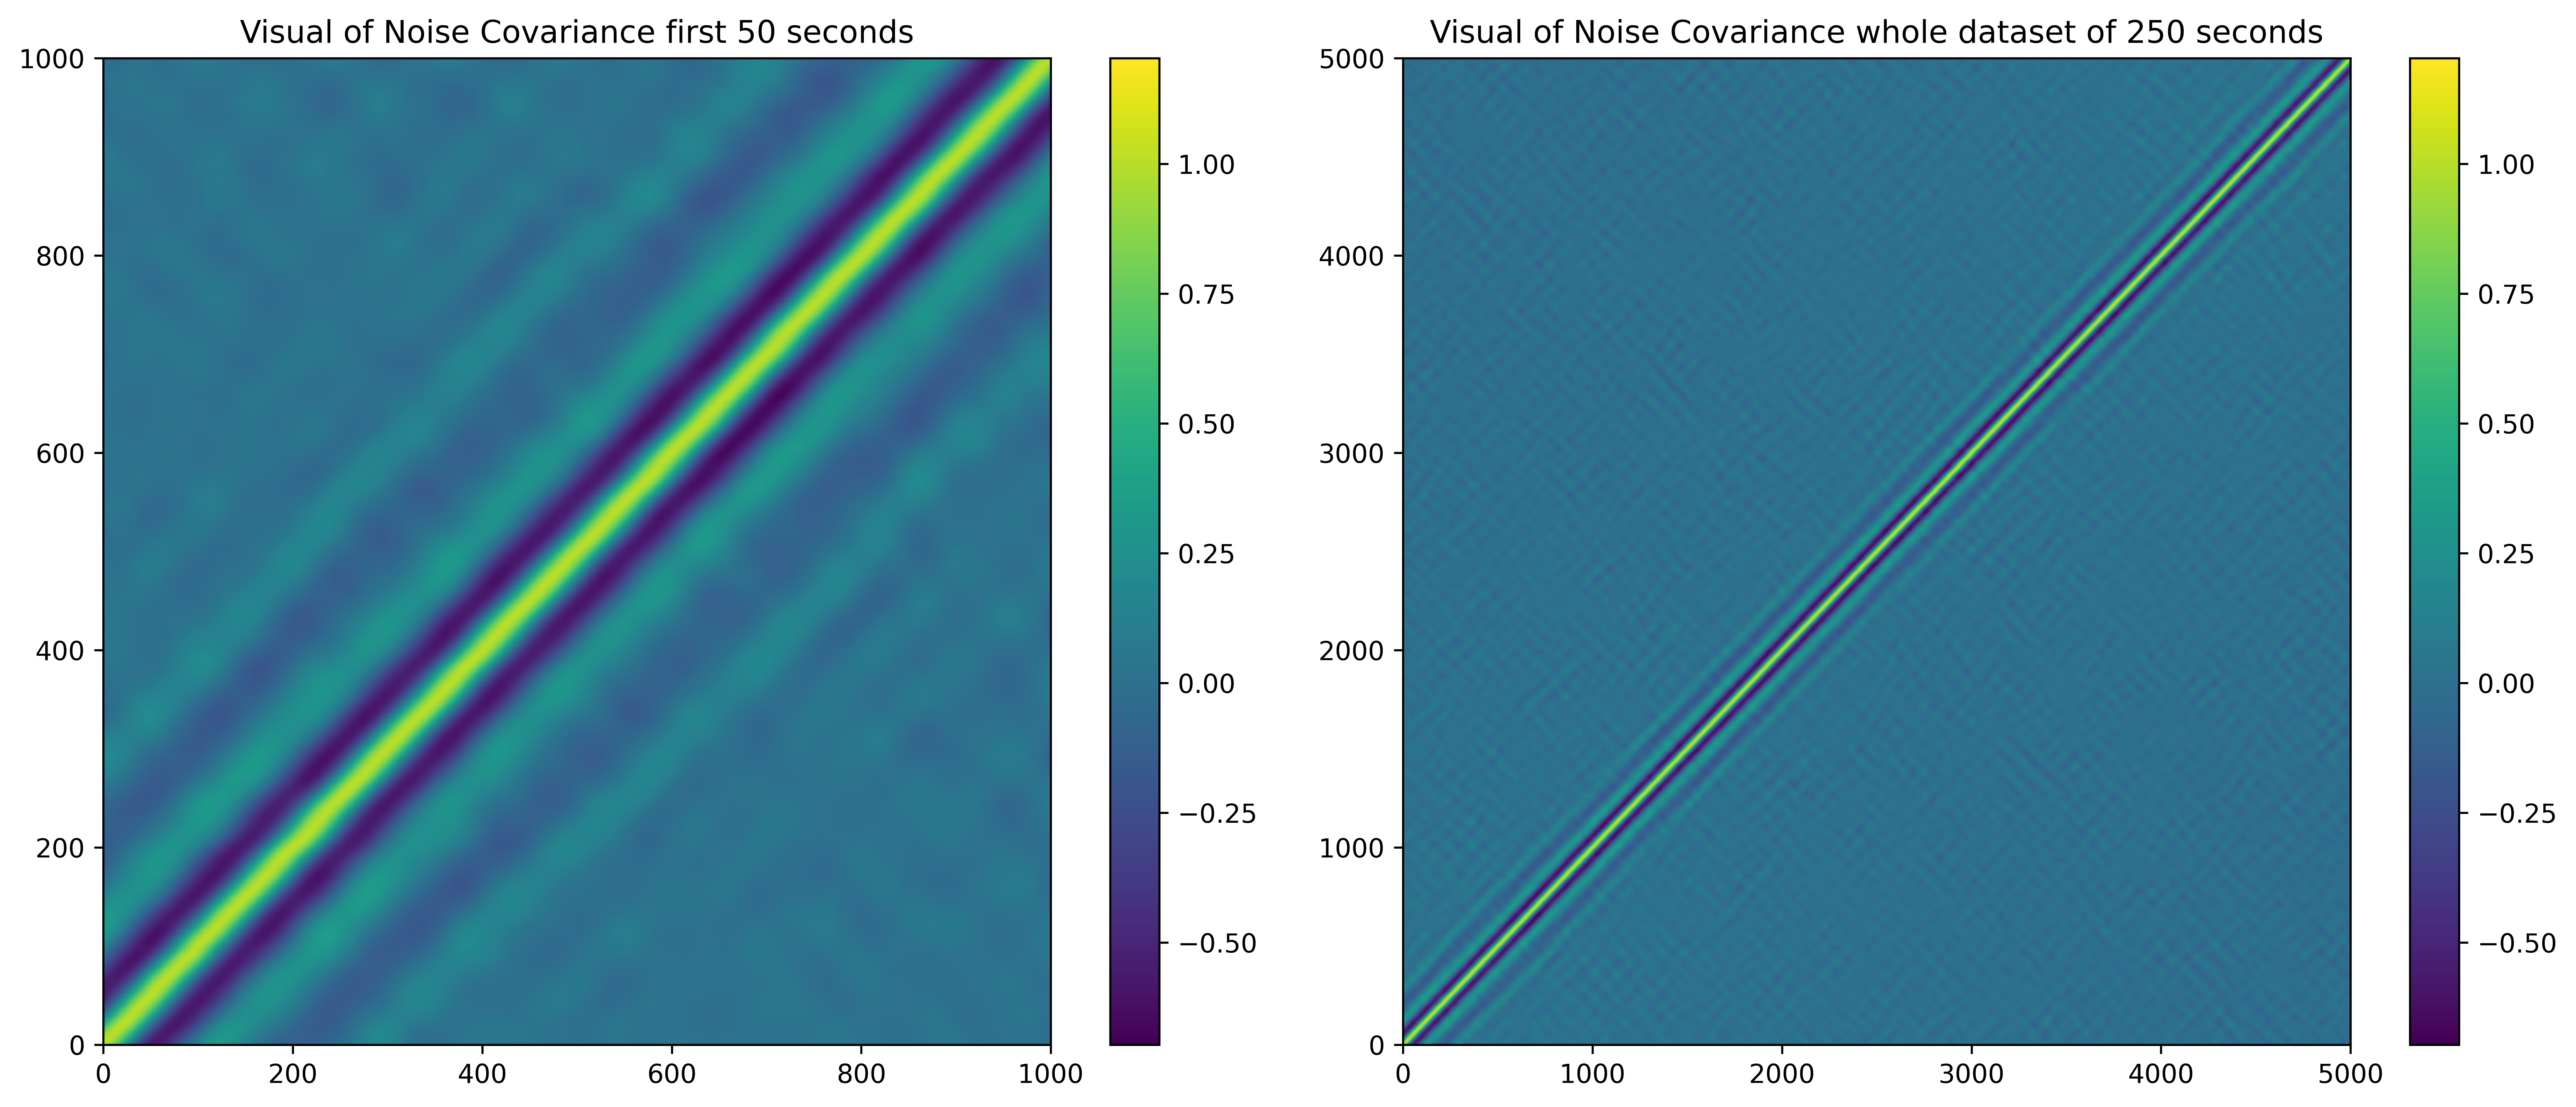

In [15]:
plt.figure(1, figsize=(14, 6), dpi=600)

plt.subplot(1, 2, 1)
plt.title('Visual of Noise Covariance first 50 seconds')
plt.pcolormesh(anmo_raw_resampled_arr_cutoff_covar[:1000,:1000])
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title('Visual of Noise Covariance whole dataset of 250 seconds')
plt.pcolormesh(anmo_raw_resampled_arr_cutoff_covar)
plt.colorbar()

plt.tight_layout()
plt.show()

#### Estimating Correlation as a Function of Lag Time

In [62]:
#anmo_raw_resampled_arr_cutoff_covar.shape,n

#np.diag(anmo_raw_resampled_arr_cutoff_covar,-2)

In [54]:
corr_func_lag_time = []
n = len(anmo_raw_resampled_arr_cutoff_covar)

for i in range(0,n):
    corr_func_lag_time.append(np.mean(np.diag(anmo_raw_resampled_arr_cutoff_covar,-i)))

/scratch/sswar/tmp/ipykernel_150021/1296744969.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(scaled_ticks)  # Set the display values


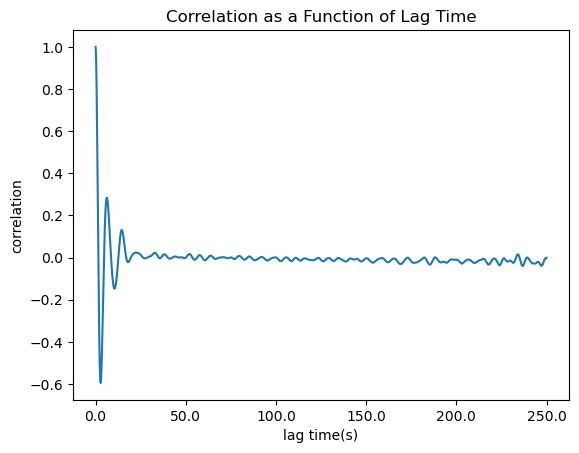

In [55]:
fig, ax = plt.subplots()
x = np.arange(0,5000)
y = corr_func_lag_time

ax.plot(x,y)
current_ticks = ax.get_xticks()
scaled_ticks = current_ticks * 250 / 5000
ax.set_xticklabels(scaled_ticks)  # Set the display values

ax.set_xlabel('lag time(s)')
ax.set_ylabel('correlation')

ax.set_title('Correlation as a Function of Lag Time')
plt.show()

#### Use the Parameters to Generate the Noise and Plot theDiagram of Actual Noise With Parameterized Noise

In [3]:
list_param = []

for i in range(0,50):
    list_param.append(np.exp(-0.2*i)*math.cos(0.2*4.4*i))    

In [4]:
list_param_mat = np.zeros([2000,2000])

##To generate the noise parametrized matrix for 50 seconds, I am taking 2000 samples with 40HZ sampling rate. 
##Thus 2000/40 gives 50 sec of data. Therefore in the equation also there is a division of time lag by 40.
for i in range(0,2000):
    for j in range(0,2000):
        noise_val = np.exp(-0.2*np.abs(j-i)/40)*math.cos(0.2*4.4*np.abs(j-i)/40)
        list_param_mat[i,j] = noise_val
        
print(list_param_mat.shape)

(2000, 2000)


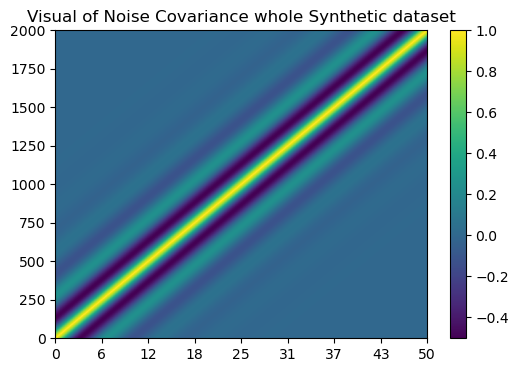

In [5]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.set_title('Visual of Noise Covariance whole Synthetic dataset')
im1 = ax.pcolormesh(list_param_mat)
x_ticks = ax.get_xticks()
x_ticks_lables = x_ticks/40
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks_lables.astype(int))
fig.colorbar(im1, ax=ax)

plt.show()

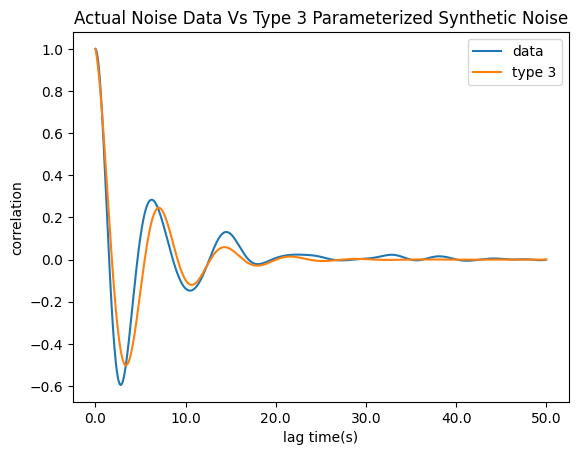

In [19]:
fig, ax = plt.subplots()
x = np.arange(0,1000)
y = corr_func_lag_time[:1000]

x1 = np.linspace(0,1000,50)
y1 = list_param

x1_new = np.linspace(0,1000,1000)
bspline = interpolate.make_interp_spline(x1, y1)
y1_new = bspline(x1_new)

ax.plot(x,y, label='data')
#ax.plot(x1,y1, label='type 3')
ax.plot(x1_new,y1_new, label='type 3')

current_ticks = ax.get_xticks()
scaled_ticks = current_ticks * 50 / 1000
ax.set_xticklabels(scaled_ticks)
ax.set_xlabel('lag time(s)')
ax.set_ylabel('correlation')
ax.legend()
ax.set_title('Actual Noise Data Vs Type 3 Parameterized Synthetic Noise')
plt.show()

### Finding the Noise Parameters Through Optimization

In [192]:
def func(t, lambda_, omega_0):
    return np.exp(-lambda_ * t) * np.cos(lambda_ * omega_0 * t)

In [188]:
#temp = np.mean(np.array(corr_func_lag_time).reshape(-1,20), axis=1)
temp = decimate(corr_func_lag_time,20)

In [189]:
from scipy.optimize import curve_fit

t = np.array(np.arange(0,250))

params, covariance = curve_fit(func, t, temp)
lambda_opt, omega_opt = params

In [190]:
lambda_opt

0.20322691697193232

In [191]:
omega_opt

4.6858432705031356